In [1]:
!pip install surprise
!pip install sklearn

You should consider upgrading via the '/Users/kevindeloria/.pyenv/versions/3.9.0/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/kevindeloria/.pyenv/versions/3.9.0/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Data Set

In [3]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head(20)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


# Exploratory Data Analysis

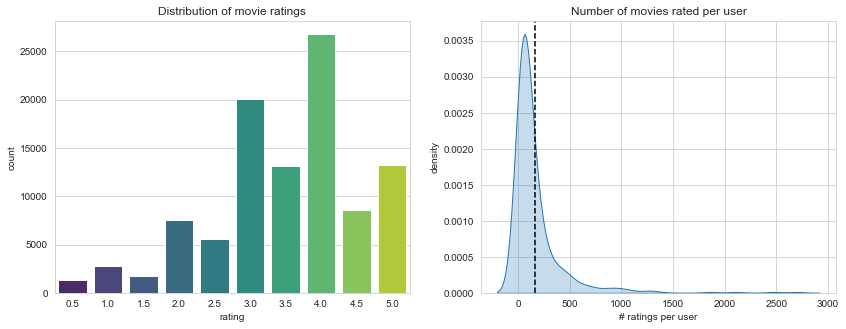

In [5]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

Rating is left skewed, movie ratings per user is right skewed. Data is sparse.

# Surprise! Training - 5 folds

In [6]:
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD

ratings = ratings[['userId', 'movieId', 'rating']]

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8716  0.8684  0.8758  0.8737  0.8802  0.8739  0.0040  
MAE (testset)     0.6721  0.6685  0.6720  0.6723  0.6758  0.6722  0.0023  
Fit time          3.84    3.83    3.91    3.90    4.18    3.93    0.13    
Test time         0.19    0.12    0.12    0.18    0.12    0.14    0.03    


{'test_rmse': array([0.87158346, 0.8684051 , 0.87583714, 0.87370006, 0.8801651 ]),
 'test_mae': array([0.67211428, 0.66849259, 0.67203275, 0.67232914, 0.67581032]),
 'fit_time': (3.839202880859375,
  3.825490951538086,
  3.9107768535614014,
  3.8998589515686035,
  4.183665990829468),
 'test_time': (0.1907498836517334,
  0.11557698249816895,
  0.11615681648254395,
  0.1805250644683838,
  0.12144207954406738)}

In [7]:
algo.fit(data.build_full_trainset())

# Check User 196

In [19]:
g = ratings[(ratings['userId'] == 196) & (ratings['movieId'] == 62)]
g

,userId,movieId,rating
28274,196,62,4.5


In [23]:
uid = 196  # raw user id (as in the ratings file)
iid = 62  # raw item id (as in the ratings file)

# get a prediction for specific user, movie id, and the expected rating (4.5 in our case)
pred = algo.predict(uid, iid, r_ui=4.5, verbose=True)

user: 196        item: 62         r_ui = 4.50   est = 3.81   {'was_impossible': False}


In [24]:
pred.est # the correct value is 4.5 - est is 3.5, so something is up

3.809106593323624

# Addressing cold start

https://github.com/topspinj/recommender-tutorial/blob/master/part-2-cold-start-problem.ipynb

In [11]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [12]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")

movies = movies[movies['genres']!='(no genres listed)']

del genres_counts['(no genres listed)']

genres_counts

There are 20 genre labels.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87})

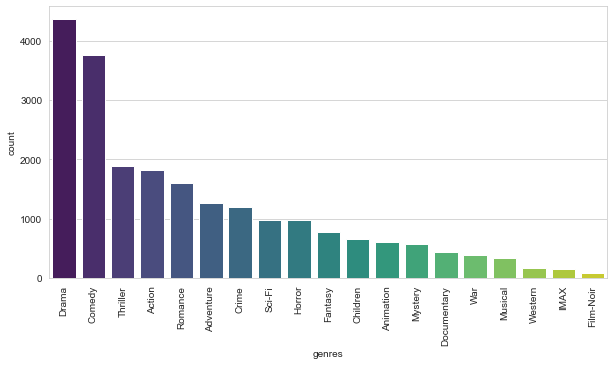

In [13]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()